In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from category_encoders import MEstimateEncoder
import sklearn
sklearn.set_config(transform_output="pandas")
from scipy import stats
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

In [4]:
%%capture

%run cleaning_marc_final.ipynb ;

# 3.  Predictions : TotalGHGEmissions

In [7]:
possible_features = ['floor_building', 'is_campus ',' p_gas ',' p_elec ',' p_steam ',' WN_ratio ',' Data_Center ',' Other ',' Hotel ',' SupermarketGrocery_Store ',' Medical_Office ',' Other___Recreation ',' Senior_Care_Community ',' Laboratory ',' Hospital_General_Medical_and_Surgical']
i = 0
while i < len(possible_features):
    possible_features[i] = possible_features[i].strip()
    i+=1

In [8]:
features = ['NumberofBuildings' , 'NumberofFloors' , 'is_laboratory' , 'is_hospital' , 'p_gas' , 'p_steam' , 'PropertyGFABuildings' , 'LargestPropertyUseType_SupermarketGrocery_Store' , 'LargestPropertyUseType_Senior_Care_Community' ,'LargestPropertyUseType_Data_Center' , 'LargestPropertyUseType_Hotel']
# a corriger
X_GHG = ols_df[possible_features].to_numpy()
y_GHG = ols_df['TotalGHGEmissions'].to_numpy()
X_train_GHG, X_test_GHG , y_train_GHG, y_test_GHG = train_test_split(X_GHG,y_GHG,test_size=0.2, random_state=33)

In [9]:
rf = RandomForestRegressor()
param_rf = {'n_estimators':[i for i in range(1,20,1)],
           'max_depth':[i for i in range(1,10,1)]}
regr = GridSearchCV(rf,param_grid=param_rf,scoring='r2',cv=5,refit=True)
regr.fit(X_train_GHG,y_train_GHG)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19]},
             scoring='r2')

In [10]:
regr.score(X_train_GHG,y_train_GHG)

0.9313628574141126

In [11]:
params = regr.best_params_
params

{'max_depth': 7, 'n_estimators': 15}

In [12]:
final_rf = RandomForestRegressor(n_estimators = params['n_estimators'],max_depth=params['max_depth'])
final_rf.fit(X_train_GHG,y_train_GHG)
metrics.r2_score(y_test_GHG,final_rf.predict(X_test_GHG))

0.9027137917139375

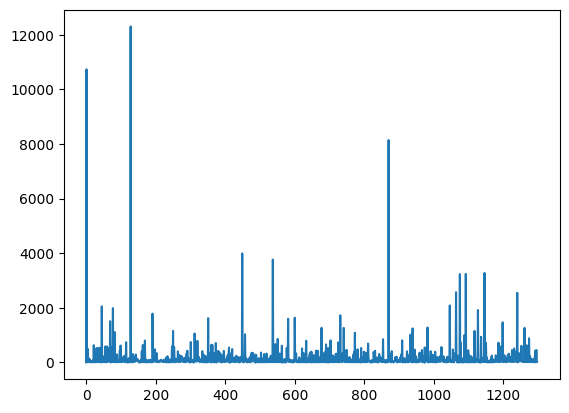

In [35]:
plt.plot(y_train_GHG)

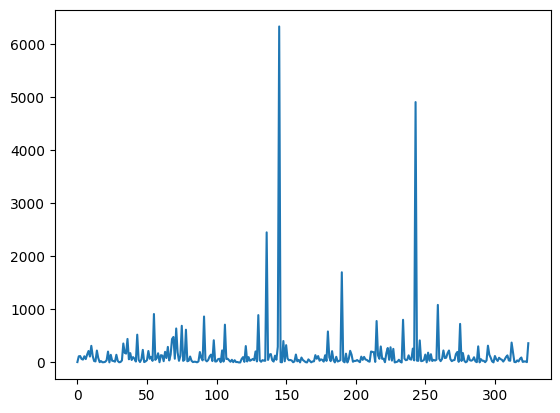

In [36]:
plt.plot(y_test_GHG)

# 4.  Prediction : SiteEnergyUsekBtu

In [14]:
possible_features_E = ['Neighborhood_northeast','floor_building',' is_campus ',' decennie ',' Data_Center ',' Office ',' Non_Refrigerated_Warehouse ',' K_12_School ',' Retail_Store ',' Other ',' Hotel ',' Distribution_Center ',' SupermarketGrocery_Store ',' Medical_Office ',' Other___Recreation ',' CollegeUniversity ',' Other___EntertainmentPublic_Assembly ',' Senior_Care_Community ',' Laboratory ',' Restaurant ',' Refrigerated_Warehouse ',' SocialMeeting_Hall ',' Hospital_General_Medical_and_Surgical ',' Multifamily_Housing ',' Strip_Mall' ]
i = 0
while i < len(possible_features_E):
    possible_features_E[i] = possible_features_E[i].strip()
    i+=1

In [15]:
#features = ['WN_ratio', 'YearBuilt' ,'NumberofBuildings', 'is_laboratory','LargestPropertyUseType_Hospital_General_Medical_and_Surgical', 'is_campus' , 'PropertyGFABuildings' , 'LargestPropertyUseType_SupermarketGrocery_Store','LargestPropertyUseType_Data_Center' , 'LargestPropertyUseType_Hotel']
# a corriger
X_energy = ols_df[possible_features_E]
y_energy = ols_df['SiteEnergyUseWNkBtu']

## 4.0 ACP

In [16]:
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression



plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs



def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


In [17]:
X_scaled = (X_energy - X_energy.mean(axis=0)) / X_energy.std(axis=0)

In [18]:
X_pca

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24
0,-0.198466,-0.044483,-0.232122,0.437879,1.286144,-0.957238,0.115130,0.129386,-0.105071,-0.457875,...,0.139883,0.282538,-0.819918,-0.537148,0.003870,-0.452418,0.836741,0.044753,0.054722,-0.102109
1,0.313025,-0.170366,-0.348245,0.089387,1.490966,0.352723,0.211818,0.224993,-0.435949,-0.026770,...,-0.246536,-0.052504,-0.542318,-0.881754,0.489871,-0.417689,-0.748900,-0.095720,0.189418,0.061759
2,5.460704,-0.097844,-1.219177,-1.151030,10.676398,-2.088826,3.102097,1.748262,-1.642274,-2.101700,...,0.209655,1.175941,-3.097885,-7.312606,2.448407,-5.543282,4.106079,0.161730,-0.891124,0.944399
3,-0.328987,-0.038001,-0.191942,0.468740,0.900529,-0.897030,0.000537,0.064965,-0.047624,-0.381775,...,0.136387,0.237787,-0.716630,-0.274558,-0.086455,-0.258486,0.695289,0.041412,0.089153,-0.050798
4,0.352106,-0.073589,-0.463443,-0.393163,1.813624,-0.152663,0.291044,0.238326,-0.287215,-0.256628,...,-0.019436,0.219079,-0.568525,-1.052734,0.372968,-1.239694,0.022872,-0.003363,0.134883,-0.005524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,-0.116177,-0.039772,-0.306250,-0.388090,0.037644,0.255319,-0.229482,-0.056022,-0.039305,0.138067,...,-0.063246,-0.006315,-0.039923,0.113517,0.000657,-0.440091,-0.792561,-0.033509,0.314909,0.181298
3372,-0.160552,-0.080589,-0.393005,-0.538359,-0.107615,0.258656,0.297753,0.304547,0.059648,0.427540,...,-0.248424,0.043600,-0.207385,0.441129,0.497149,-0.615758,-0.918920,-0.047849,0.310301,0.261100
3373,-0.311364,-0.053711,-0.274413,-0.132489,-0.031120,-0.102873,0.011760,0.107134,0.049575,0.152515,...,-0.082233,0.067270,-0.275305,0.340287,0.133591,-0.304196,-0.434085,-0.014832,0.258499,0.207380
3374,-0.194982,-0.061627,-0.330066,-0.388962,-0.009638,0.209132,-0.011220,0.094687,0.004922,0.238537,...,-0.129174,0.020907,-0.129817,0.263521,0.187491,-0.483377,-0.768655,-0.029200,0.302227,0.246069


In [19]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(0,X_pca.shape[1])]
X_pca_df = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24
0,-0.198466,-0.044483,-0.232122,0.437879,1.286144,-0.957238,0.115130,0.129386,-0.105071,-0.457875,...,0.139883,0.282538,-0.819918,-0.537148,0.003870,-0.452418,0.836741,0.044753,0.054722,-0.102109
1,0.313025,-0.170366,-0.348245,0.089387,1.490966,0.352723,0.211818,0.224993,-0.435949,-0.026770,...,-0.246536,-0.052504,-0.542318,-0.881754,0.489871,-0.417689,-0.748900,-0.095720,0.189418,0.061759
2,5.460704,-0.097844,-1.219177,-1.151030,10.676398,-2.088826,3.102097,1.748262,-1.642274,-2.101700,...,0.209655,1.175941,-3.097885,-7.312606,2.448407,-5.543282,4.106079,0.161730,-0.891124,0.944399
3,-0.328987,-0.038001,-0.191942,0.468740,0.900529,-0.897030,0.000537,0.064965,-0.047624,-0.381775,...,0.136387,0.237787,-0.716630,-0.274558,-0.086455,-0.258486,0.695289,0.041412,0.089153,-0.050798
4,0.352106,-0.073589,-0.463443,-0.393163,1.813624,-0.152663,0.291044,0.238326,-0.287215,-0.256628,...,-0.019436,0.219079,-0.568525,-1.052734,0.372968,-1.239694,0.022872,-0.003363,0.134883,-0.005524


In [20]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X_energy.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
Neighborhood_northeast,-0.074713,-0.096615,-0.059279,-0.138077,-0.243087,0.096785,0.589182,0.109442,0.040835,-0.074643,...,0.084403,0.011922,0.154647,-0.432248,-0.473535,0.236695,0.050951,0.035943,-0.032784,-0.025613
floor_building,0.670383,0.039005,0.048108,-0.053379,-0.042750,-0.120957,0.044248,0.003205,-0.010031,-0.005801,...,0.037916,-0.034132,-0.016941,-0.049983,0.002726,0.042521,0.193878,0.024721,-0.063523,0.686207
is_campus,-0.034816,-0.376438,0.577947,-0.145998,0.020254,0.013098,0.004542,0.003287,0.003713,0.011800,...,-0.016880,-0.011833,0.049071,0.007628,0.000344,-0.040907,0.092838,-0.692625,-0.089250,0.002336
decennie,-0.185079,0.012814,0.100258,0.432317,-0.017792,-0.488737,-0.013715,-0.014020,0.058893,-0.164612,...,0.091318,0.065297,-0.211815,0.095052,-0.138476,0.296239,0.554099,0.029686,-0.070736,-0.064184
Data_Center,0.067985,0.005219,-0.025538,-0.062862,-0.130746,-0.094250,-0.040266,-0.100411,0.034735,0.045405,...,-0.055920,0.040565,0.127856,-0.007414,0.102453,0.051502,0.071315,0.003379,-0.029232,-0.011339
Office,0.646198,0.077862,0.043396,-0.037906,-0.248540,-0.135559,-0.031108,-0.051841,0.041824,-0.016845,...,-0.003505,-0.016064,-0.057250,-0.001552,-0.030559,0.062357,-0.040426,-0.058855,0.020519,-0.678793
Non_Refrigerated_Warehouse,-0.068017,0.594728,0.339018,-0.037778,0.005023,0.081596,0.094946,0.036912,0.001302,-0.011750,...,-0.001562,0.005348,-0.013747,0.011436,-0.011070,-0.027732,-0.098735,0.049614,-0.696294,-0.019805
K_12_School,-0.068339,-0.076629,-0.103474,-0.255558,-0.133771,0.105302,0.175815,-0.268833,-0.594644,-0.193283,...,-0.070376,-0.072011,0.117927,0.056127,0.364229,0.175859,0.290419,0.057235,-0.101884,-0.059926
Retail_Store,0.041126,-0.012099,0.046537,0.336636,-0.117831,0.182067,0.113247,-0.162045,0.342236,-0.205434,...,0.160294,0.506333,0.379403,-0.157581,0.402618,-0.051912,0.004755,-0.016151,0.019305,0.012052
Other,0.136097,-0.161685,0.170501,0.393152,-0.010055,0.461044,0.048771,0.048582,-0.121699,0.054486,...,-0.099532,-0.211257,0.191041,0.238992,-0.209662,-0.349504,0.349765,0.247824,-0.056724,-0.095741


array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

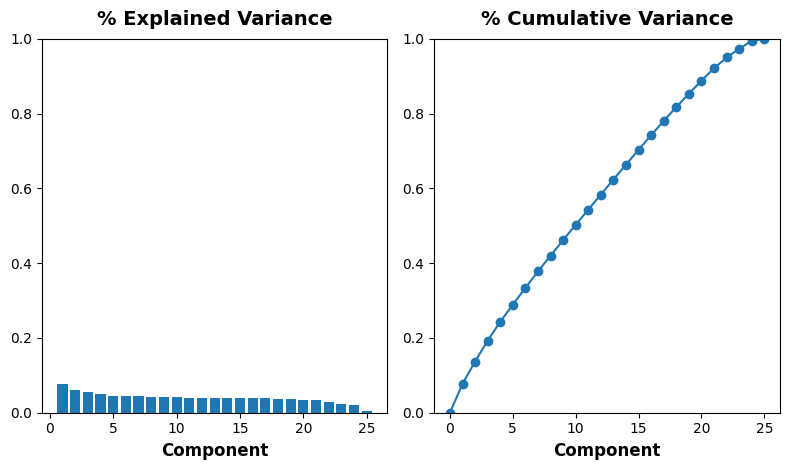

In [21]:
plot_variance(pca)

In [22]:
mi_scores = make_mi_scores(X_pca, y_energy, discrete_features=False)
mi_scores

pca4     0.303093
pca0     0.295475
pca14    0.248119
pca24    0.235342
pca22    0.209703
pca1     0.209439
pca7     0.206101
pca5     0.191880
pca16    0.168346
pca15    0.168251
pca10    0.152901
pca11    0.145607
pca6     0.144577
pca9     0.142530
pca19    0.138143
pca3     0.129245
pca12    0.124289
pca17    0.123983
pca8     0.122676
pca2     0.117971
pca13    0.113340
pca20    0.107924
pca18    0.106258
pca21    0.103865
pca23    0.097211
Name: MI Scores, dtype: float64

In [37]:
# nécessaires pour la réalisation d'une ACP 
from sklearn import preprocessing
from sklearn import decomposition

#On choisit ici 2 composantes
pca = decomposition.PCA(n_components=20)
pca.fit(X_scaled)

PCA(n_components=20)

In [40]:
# On affiche le pourcentage de variance expliquée par chacune des composantes ainsi que leur somme
print(pca.explained_variance_ratio_)
print('proportion de variance expliquée : ',pca.explained_variance_ratio_.sum())

[0.07735096 0.05958372 0.05616522 0.05008445 0.04586261 0.04466784
 0.04429273 0.04201525 0.04177485 0.04105478 0.04043025 0.04023959
 0.04015012 0.03994465 0.03976533 0.03886337 0.03838716 0.03709727
 0.03546511 0.03484874]
proportion de variance expliquée :  0.8880440068719015


(-0.7, 0.7)

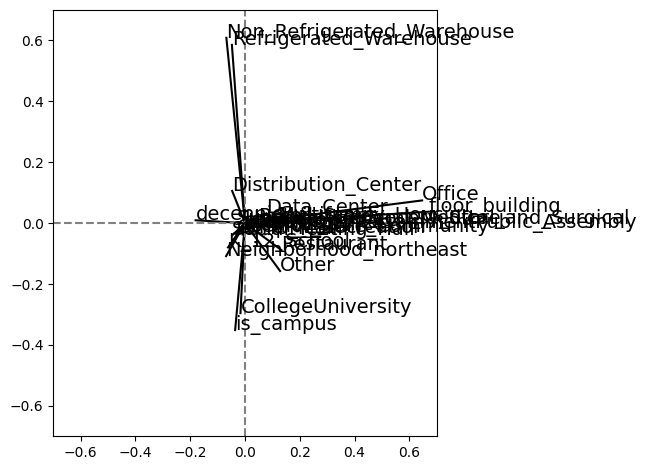

In [32]:
pcs = pca.components_

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, X_scaled.columns[i], fontsize='14')

# Afficher une ligne horizontale y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])

In [61]:
# ajout de pca14 à X_energy
X_energy['PC1'] =X_pca['pca1'].values
X_energy['PC4'] =X_pca['pca4'].values

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_11576\4111145773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_energy['PC1'] =X_pca['pca1'].values
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_11576\4111145773.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_energy['PC4'] =X_pca['pca4'].values


## 4.1 train test séparation

In [64]:
X_train_energy, X_test_energy , y_train_energy, y_test_energy = train_test_split(X_energy,y_energy,test_size=0.2, random_state=12)

## 4.2 target encoding ??

In [63]:
from category_encoders import MEstimateEncoder

# Create the encoder instance. Choose m to control noise.
encoder = MEstimateEncoder(cols=["Neighborhood_northeast"], m=5.0)

# Fit the encoder on the encoding split.
encoder.fit(X_train_energy, y_train_energy)

# Encode the Zipcode column to create the final training data
X_train_energy_encoded = encoder.transform(X_train_energy)
X_test_energy_encoded = encoder.transform(X_test_energy)

## 4.3 model et predictions

In [65]:
rf = RandomForestRegressor()
param_rf = {'n_estimators':[i for i in range(1,20,1)],
           'max_depth':[i for i in range(1,10,1)]}
regr = GridSearchCV(rf,param_grid=param_rf,scoring='r2',cv=5,refit=True)
regr.fit(X_train_energy,y_train_energy)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19]},
             scoring='r2')

In [ ]:
# rs = 12 : 0.7164 ( sans target & pca14); 0.73 avec (NumberofBuildings encoded)
# rs = 20 : 0.36 ( "decennie + nbr buildings") , 0.41
# rs = 42 : 0.57( sans target & pca14), 0.62(pca14), 0.632(target + pca 14)

In [66]:
regr.score(X_train_energy,y_train_energy)

0.9411796934392317

In [67]:
params = regr.best_params_
params

{'max_depth': 9, 'n_estimators': 15}

In [68]:
final_rf = RandomForestRegressor(n_estimators = params['n_estimators'],max_depth=params['max_depth'])
final_rf.fit(X_train_energy,y_train_energy)
metrics.r2_score(y_test_energy,final_rf.predict(X_test_energy))

0.64809420812815

In [ ]:
res_energy = pd.DataFrame(y_test_energy)
res_energy['preds'] = final_rf.predict(X_test_energy)
res_energy['diff'] = res_energy.apply(lambda x : x['preds'] - x[0] , axis =1 )
plt.plot(res_energy['diff'])

In [ ]:
plt.plot(y_test_energy)

In [ ]:
plt.plot(y_train_energy)